# Data Preprocessing

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import sentencepiece as spm

In [3]:
data_path = os.path.join("Liu_Kheyer_Retrosynthesis_Data")
train_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")

In [4]:
import pandas as pd
train_reactants_df = pd.read_csv(os.path.join(
    train_path, "train_targets.txt"), header=None)
train_products_df = pd.read_csv(os.path.join(
    train_path, "train_sources.txt"), header=None)

reaction_type
<RX_1>     0.302231
<RX_2>     0.238102
<RX_6>     0.166954
<RX_3>     0.112693
<RX_7>     0.091609
<RX_9>     0.036648
<RX_4>     0.017987
<RX_8>     0.016263
<RX_5>     0.012991
<RX_10>    0.004522
Name: count, dtype: float64

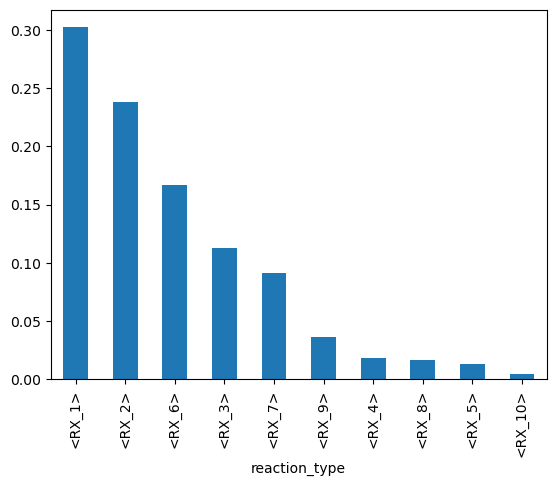

In [5]:
def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(
        r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "", regex=True)
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


df = process_dfs(train_reactants_df, train_products_df)
rxns = df["reaction_type"].value_counts(ascending=False)/df.shape[0]
rxns.plot.bar()
rxns

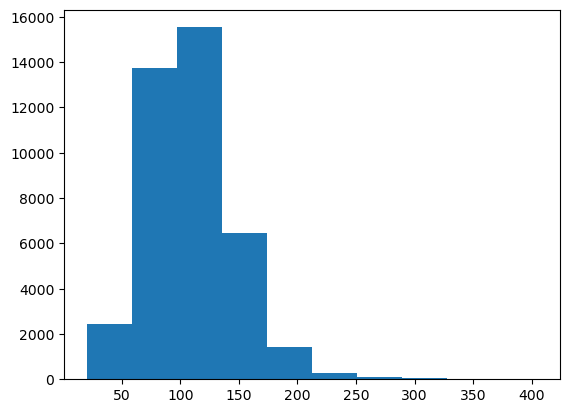

count    40029.000000
mean       108.364461
std         36.524828
min         20.000000
25%         81.000000
50%        105.000000
75%        130.000000
max        405.000000
Name: full_input_format_delimited, dtype: float64


'[BOS]CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl>>O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1[EOS]'

In [11]:
def prepare_whole_reaction_padded(df):
    df["full_input_format_delimited"] = "[BOS]" + \
        df["reactants"]+">>"+df["products"]+"[EOS]"
    df["full_input_format_delimited"] = df["full_input_format_delimited"].str.replace(
        " ", "")
    df["full_input_format"] = df["reactants"].str.replace(
        " ", "")+">>"+df["products"].str.replace(" ", "")


prepare_whole_reaction_padded(df)
plt.hist(df["full_input_format_delimited"].str.len())
plt.show()
print(df["full_input_format_delimited"].str.len().describe())
df.loc[0, "full_input_format_delimited"]

In [13]:
(df["full_input_format_delimited"].str.len() > 300).sum()

33

We need first to create the vocabulary for the training and target data:

In [14]:
spt_1 = spm.SentencePieceTrainer.train(
    "--input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1")
sp = spm.SentencePieceProcessor()
sp.load('m.model')
print(sp.get_piece_size())
vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]
print(vocabs)

56
['<unk>', '[BOS]', '[EOS]', '[PAD]', '.', '▁', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '>', '@', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's', 't', 'u']


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Let's check the vocabulary created by the trainer by encoding the first example:

In [26]:
print(len(df["full_input_format_delimited"][0]))
print(sp.encode_as_pieces(df["full_input_format_delimited"][0]))
print(sp.encode_as_ids(df["full_input_format_delimited"][0]))

160
['▁', '[BOS]', 'C', 'S', '(', '=', 'O', ')', '(', '=', 'O', ')', 'O', 'C', '[', 'C', '@', 'H', ']', '1', 'C', 'C', 'C', '(', '=', 'O', ')', 'O', '1', '.', 'F', 'c', '1', 'c', 'c', 'c', '(', 'N', 'c', '2', 'n', 'c', 'n', 'c', '3', 'c', 'c', '(', 'O', 'C', 'C', 'N', '4', 'C', 'C', 'N', 'C', 'C', '4', ')', 'c', '(', 'O', 'C', '4', 'C', 'C', 'C', 'C', '4', ')', 'c', 'c', '2', '3', ')', 'c', 'c', '1', 'C', 'l', '>', '>', 'O', '=', 'C', '1', 'C', 'C', '[', 'C', '@', 'H', ']', '(', 'C', 'N', '2', 'C', 'C', 'N', '(', 'C', 'C', 'O', 'c', '3', 'c', 'c', '4', 'n', 'c', 'n', 'c', '(', 'N', 'c', '5', 'c', 'c', 'c', '(', 'F', ')', 'c', '(', 'C', 'l', ')', 'c', '5', ')', 'c', '4', 'c', 'c', '3', 'O', 'C', '3', 'C', 'C', 'C', 'C', '3', ')', 'C', 'C', '2', ')', 'O', '1', '[EOS]']
[5, 1, 25, 36, 7, 21, 33, 8, 7, 21, 33, 8, 33, 25, 38, 25, 23, 27, 40, 12, 25, 25, 25, 7, 21, 33, 8, 33, 12, 4, 26, 43, 12, 43, 43, 43, 7, 32, 43, 13, 49, 43, 49, 43, 14, 43, 43, 7, 33, 25, 25, 32, 15, 25, 25, 32, 25, 25, 

Convert reaction smarts to fingerprints

In [27]:
from rdkit import Chem
params = Chem.rdChemReactions.ReactionFingerprintParams()
params.fpSize = 2048
df["rxn"] = df.apply(lambda x: Chem.rdChemReactions.ReactionFromSmarts(
    x["full_input_format"], useSmiles=True), axis=1)
df["fingerprint"] = df.apply(
    lambda x: Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(x["rxn"], params), axis=1)

Now we can tokenize the training data:

In [31]:
PAD_TOKEN = sp.encode_as_ids("[PAD]")[1]
BOS_TOKEN = sp.encode_as_ids("[BOS]")[1]


def tokenize_and_pad(df, max_len=0):
    # choose to set the max_len based on a user entered value or the one derived from the data
    if max_len == 0:
        max_val = df["input_ids"].str.len().sort_values(
            ascending=False).head(1).values[0]
        print(max_val)
        return
    else:
        max_val = max_len
    # Create the encoded columns
    df["input_ids"] = df["full_input_format_delimited"].apply(
        sp.encode_as_ids).apply(lambda x: x[1:])
    print(df["input_ids"].apply(len).describe())
    df_new = df[df["input_ids"].apply(len) <= max_val].copy()
    print("removed ", df.shape[0]-df_new.shape[0], " samples")

    # calculate how much to pad for each case
    df_new["input_counts"] = max_val-df_new["input_ids"].str.len()

    # pad with the PAD_TOKEN
    df_new["input_ids"] = df_new.apply(lambda row: np.pad(
        row["input_ids"], (0, row["input_counts"]), mode='constant', constant_values=(0, PAD_TOKEN)), axis=1)

    return np.asarray(df_new["input_ids"].values.tolist()), max_val, df_new


train_inputs, train_input_len, df_with_max_200 = tokenize_and_pad(df, 200)
df_with_max_200["input_ids"].apply(len).describe()

count    40029.000000
mean       100.364461
std         36.524828
min         12.000000
25%         73.000000
50%         97.000000
75%        122.000000
max        397.000000
Name: input_ids, dtype: float64
removed  474  samples


count    39555.0
mean       200.0
std          0.0
min        200.0
25%        200.0
50%        200.0
75%        200.0
max        200.0
Name: input_ids, dtype: float64

In [ ]:
fingerprints = []
for i in df_with_max_200.index:
    array = np.zeros((0, ), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(
        df_with_max_200.loc[i, "fingerprint"], array)
    fingerprints.append(array)
len(fingerprints)

In [ ]:
"""df_rxn_10=df[(df["reaction_type"]=="<RX_10>")].copy()
train_inputs,train_input_len,df_rxn_10_max_200=tokenize_and_pad(df_rxn_10,200)
fingerprints=[]
for i in df_rxn_10_max_200.index:
  array=np.zeros((0, ), dtype=np.float64)
  Chem.DataStructs.ConvertToNumpyArray(df_rxn_10_max_200.loc[i,"fingerprint"], array)
  fingerprints.append(array)
with open(os.path.join(train_path,"train_targets_ids_200_rxn10.data"), "w") as f:
  np.savetxt(f, train_inputs,newline='\n')
with open(os.path.join(train_path,"train_targets_ids_fingerprints_200_rxn10.data"), "w") as f:
  np.savetxt(f, fingerprints,newline='\n')

import numpy as np
from sklearn_extra.cluster import KMedoids
from time import time
fingerprints_10=[]
for i in df_with_max_200.index:
  if(df_with_max_200.loc[i,"reaction_type"]=="<RX_10>"):
    array=np.zeros((0, ), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(df_with_max_200.loc[i,"fingerprint"], array)
    fingerprints_10.append(array)
def find_centroids(,fps):
  centroids=[]
  cluster_els=fps
  nb_of_clusters=int(np.floor(len(cluster_els)*0.05))
  print(len(cluster_els),nb_of_clusters)
  kmed=KMedoids(metric='jaccard',n_clusters=nb_of_clusters, random_state=48,init='k-medoids++').fit(cluster_els)
  centroids.append(kmed.cluster_centers_)
  print("inertia:",kmed.inertia_)
  return np.vstack(centroids)


centroids=find_centroids(np.array(fingerprints_10))
centroids_strings=[]
for i in centroids:
  select=[np.array_equal(i,j) for j in fingerprints]
  if(np.sum(select))>0:
    centroids_strings.append(train_inputs[select][0])
    print(len(centroids_strings))
print(len(centroids_strings))
with open(os.path.join(train_path,"centroids_strings_200_rxn10.data"), "w") as f:
  np.savetxt(f, centroids_strings,newline='\n')
with open(os.path.join(train_path,"centroids_200_rxn10.data"), "w") as f:
  np.savetxt(f, centroids,newline='\n')
"""

181 9
inertia: 84.64804907413179


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


9

In [ ]:
"""import numpy as np
from sklearn_extra.cluster import KMedoids
from time import time
def find_centroids(fps):
    centroids=[]
    cluster_els=fps
    nb_of_clusters=int(np.floor(len(cluster_els)*0.05))
    print(len(cluster_els),nb_of_clusters)
    kmed=KMedoids(metric='jaccard',n_clusters=nb_of_clusters, random_state=48,init='k-medoids++').fit(cluster_els)
    centroids.append(kmed.cluster_centers_)
    print("inertia:",kmed.inertia_)
    return np.vstack(centroids)
from scipy.spatial.distance import cdist
def similarity(fps,centroids,metric):
  if len(fps)>0:
    sims=cdist(fps,centroids,metric)
    return 1-np.mean(np.min(sims,axis=1)),np.min(sims,axis=1)
  else:
    return 0,0

for el in ["<RX_10>","<RX_1>","<RX_2>","<RX_3>","<RX_4>","<RX_5>","<RX_6>","<RX_7>","<RX_8>","<RX_9>"]:
  df_rxn_10=df[(df["reaction_type"]==el)].copy()
  train_inputs,train_input_len,df_rxn_10_max_200=tokenize_and_pad(df_rxn_10,200)
  fingerprints=[]
  for i in df_rxn_10_max_200.index:
    array=np.zeros((0, ), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(df_rxn_10_max_200.loc[i,"fingerprint"], array)
    fingerprints.append(array)

  centroids=find_centroids(np.array(fingerprints))
  centroids_strings=[]
  for i in centroids:
    select=[np.array_equal(i,j) for j in fingerprints]
    if(np.sum(select))>0:
      centroids_strings.append(train_inputs[select][0])
  print(el,similarity(fingerprints,centroids,"jaccard")[0])
  print(el,similarity(train_inputs,centroids_strings,"cosine")[0])
"""

removed  0  samples
181 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 84.64804907413179
<RX_10> 0.4502129246939205
<RX_10> 0.7959826731307652
removed  93  samples
12005 600


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 7209.851408916508
<RX_1> 0.2647825602319377
<RX_1> 0.8545752868265527
removed  183  samples
9348 467


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 5421.6632059248595
<RX_2> 0.28677729327835366
<RX_2> 0.8478851261103875
removed  66  samples
4445 222


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 2602.3970624328504
<RX_3> 0.27275665481163247
<RX_3> 0.8324490985501043
removed  2  samples
718 35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 458.1381885603014
<RX_4> 0.22878830031247632
<RX_4> 0.8189646524713752
removed  1  samples
519 25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 242.2591721762606
<RX_5> 0.43261639618025505
<RX_5> 0.8470738431505647
removed  94  samples
6589 329


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 3439.323776330227
<RX_6> 0.37884072375040867
<RX_6> 0.8491694432904666
removed  20  samples
3647 182


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 1946.0618606799903
<RX_7> 0.36565196419899726
<RX_7> 0.8547592929451419
removed  5  samples
646 32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 372.4908224078514
<RX_8> 0.3287177408055372
<RX_8> 0.836979295515362
removed  10  samples
1457 72


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 911.5870378703984
<RX_9> 0.285955077156394
<RX_9> 0.8390922577237193


Now let's create the pipeline for validation and test data:

In [ ]:
def data_to_Ids_pipeline(reactants_df, products_df, max_len=0):
    dfa = process_dfs(reactants_df, products_df)
    prepare_whole_reaction_padded(dfa)
    inputs, input_len, dfa_new = tokenize_and_pad(dfa, max_len)
    return dfa_new, inputs, input_len

In [ ]:
valid_products_df = pd.read_csv(os.path.join(
    validation_path, "valid_sources.txt"), header=None)
valid_reactants_df = pd.read_csv(os.path.join(
    validation_path, "valid_targets.txt"), header=None)

test_products_df = pd.read_csv(os.path.join(
    test_path, "test_sources.txt"), header=None)
test_reactants_df = pd.read_csv(os.path.join(
    test_path, "test_targets.txt"), header=None)
valid_df, valid_inputs, valid_input_len = data_to_Ids_pipeline(
    valid_reactants_df, valid_products_df, max_len=200)

test_df, test_inputs, test_input_len = data_to_Ids_pipeline(
    test_reactants_df, test_products_df, max_len=200)
print("Shape of validation Ids inputs:", valid_inputs.shape)
print("Shape of Test Ids inputs:",  test_inputs.shape)

In [ ]:
with open(os.path.join(train_path, "train_targets_ids_200.data"), "w") as f:
    np.savetxt(f, train_inputs, newline='\n')
with open(os.path.join(validation_path, "validation_targets_ids_200.data"), "w") as f:
    np.savetxt(f, valid_inputs, newline='\n')
with open(os.path.join(test_path, "test_targets_ids_200.data"), "w") as f:
    np.savetxt(f, test_inputs, newline='\n')

with open(os.path.join(train_path, "train_targets_ids_200.txt"), "w") as f:
    np.savetxt(f, train_inputs, newline='\n')
with open(os.path.join(validation_path, "validation_targets_ids_200.txt"), "w") as f:
    np.savetxt(f, valid_inputs, newline='\n')
with open(os.path.join(test_path, "test_targets_ids_200.txt"), "w") as f:
    np.savetxt(f, test_inputs, newline='\n')

with open(os.path.join(train_path, "train_targets_rxns_200.data"), "w") as f:
    np.savetxt(f, df_with_max_200["reaction_type"].str.replace("<RX_", "").str.replace(
        ">", "").apply(lambda x: 0 if int(x) == 10 else int(x)).values, newline='\n')
with open(os.path.join(train_path, "train_targets_ids_fingerprints_200.data"), "w") as f:
    np.savetxt(f, fingerprints, newline='\n')

#### Using Kmedoids to select the clusters representative of each class:

In [ ]:
import numpy as np
from sklearn_extra.cluster import KMedoids
from rdkit import Chem


def find_centroids(clusters, fps):
    unique_clusters = np.unique(clusters)
    centroids = []
    for cluster in unique_clusters:
        cluster_els = fps[np.where(clusters == cluster)]
        nb_of_clusters = int(np.floor(len(cluster_els)*0.05))
        print(len(cluster_els), nb_of_clusters)
        kmed = KMedoids(metric='jaccard', n_clusters=nb_of_clusters,
                        random_state=48, init='k-medoids++').fit(cluster_els)
        centroids.append(kmed.cluster_centers_)
        print("inertia:", kmed.inertia_)
    return np.vstack(centroids)


reactions_nb = [int(t.replace("<RX_", "").replace(">", ""))
                for t in df_with_max_200["reaction_type"]]
centroids = find_centroids(reactions_nb, np.array(fingerprints))
centroids_strings = []
for i in centroids:
    select = [np.array_equal(i, j) for j in fingerprints]
    if (np.sum(select)) > 0:
        centroids_strings.append(train_inputs[select][0])
        print(len(centroids_strings))
print(len(centroids_strings))

12009 600


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 7214.776284755243
9351 467


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 5427.790960606616
4448 222


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 2604.2278944055706
718 35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 458.1381885603014
519 25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 242.2591721762606
6592 329


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 3456.3327615582803
3648 182


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 1938.6481467155695
646 32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 372.4908224078514
1457 72


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


inertia: 911.5870378703984
181 9
inertia: 84.64804907413179


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1738: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [ ]:
with open(os.path.join(train_path, "centroids_200.data"), "w") as f:
    np.savetxt(f, centroids, newline='\n')
with open(os.path.join(train_path, "centroids_strings_200.data"), "w") as f:
    np.savetxt(f, centroids_strings, newline='\n')